In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import tensorflow.keras as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Conv2D, Dropout
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import csv
import random

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [2]:
def retrieve_data(varname, filename):
    df = pd.read_csv(filename, index_col=0)
#     df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

def create_classification_data(df, lookback, features=[]):
    rows = []
    
    if features != []:
        df = df[features].copy()
    columns = ['Date', 'SP500_relative_change_perc_1'] # Date and SP500_relative_change_perc_1 from t-0 are added first as target variables 
    
    # create column names based on original with the addition of t-i where i is lookback
    for i in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
        new_columns = df.columns.tolist()[1:] # starts at 1 to exclude 'Date' column
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
    
    # create lookback data
    for i, row in enumerate(df.iterrows()):
        if i > lookback: # lookback cannot be determined for earlier rows
            new_row = [row[1][0], row[1][1]] # add target 'Date' and 'SP500_relative_change_perc_1 '
            for x in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
                add_row = df.iloc[i - x].tolist()[1:] # starts at 1 to exclude 'Date' column
                new_row = new_row + add_row
            rows.append(new_row)
    df2 = pd.DataFrame(rows)
    df2.columns = columns
    return df2

def create_train_val_test(df, year_val, year_test, perc_train=None):
    if perc_train == None:
        # assumes years_train < year_val < year_test
        df["Date"] = pd.to_datetime(df["Date"])
        
        val = df[df['Date'].dt.year == year_val]
        test = df[df['Date'].dt.year == year_test]
        train = df[df['Date'].dt.year < year_val]
    else:
        train = df.head(round(len(df) * perc_train))
        val = df.tail(len(df) - len(train))
        test = val.tail(round(0.5 * len(val)))
        val = val.head(len(val) - len(test))
    y_train = train['SP500_relative_change_perc_1']
    x_train = train.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_val = val['SP500_relative_change_perc_1']
    x_val = val.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_test = test['SP500_relative_change_perc_1']
    x_test = test.drop(['SP500_relative_change_perc_1'], axis=1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def scale_data(x):
    standard_scaler = MinMaxScaler()
    x_scaled = pd.DataFrame(standard_scaler.fit_transform(x), columns=x.columns)
    return x_scaled

In [3]:
lookback = 16
val_year = 2018
test_year = 2019

files = {
    # varname: filename
    "S&P500": "Dataset v3/SP500_reduced_data_20220425.csv",
#     "S&P500": "Dataset v3/SP500_combined_data_20220422.csv"
}

for file in files:
    df = retrieve_data(file, files[file])

df = create_classification_data(df, lookback, ['Date', 'SP500_relative_change_perc_1', 'SP500_stochastic_K_20', 'Gold_F_relative_change_perc_1'])

x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(df, val_year, test_year)

In [4]:
def label_data(y):
    positives = []
    negatives = []
    y = list(y)
    
    labels = []
    for dev in y:
        if dev >= 0:
            labels.append(1)
        else:
            labels.append(0)
    return labels
# 
y_train = label_data(y_train)
y_val = label_data(y_val)
y_test = label_data(y_test)

In [5]:
def random_baseline(y):
    counts = [0, 0]
    for i in y:
        if i == 0:
            counts[0] = counts[0] + 1
        elif i == 1:
            counts[1] = counts[1] + 1
    print(f"\tDistribution: {counts}")
    print(f"\tRandom baseline accuracy (majority class): {counts[np.argmax(np.asarray(counts))]/ len(y)}")
    
print("Random baseline training set")
random_baseline(y_train)
print("Random baseline validation set")
random_baseline(y_val)
print("Random baseline test set")
random_baseline(y_test)

Random baseline training set
	Distribution: [964, 1160]
	Random baseline accuracy (majority class): 0.5461393596986818
Random baseline validation set
	Distribution: [124, 127]
	Random baseline accuracy (majority class): 0.5059760956175299
Random baseline test set
	Distribution: [105, 147]
	Random baseline accuracy (majority class): 0.5833333333333334


In [6]:
train_date = x_train[['Date']]
x_train = x_train.drop(['Date'], axis=1)
x_train = scale_data(x_train)

val_date = x_val[['Date']]
x_val = x_val.drop(['Date'], axis=1)
x_val = scale_data(x_val)

test_date = x_test[['Date']]
x_test = x_test.drop(['Date'], axis=1)
x_test = scale_data(x_test)

In [7]:
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

print(x_train.shape, y_train.shape)

(2124, 48) (2124,)


In [8]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# y_train = to_categorical(y_train, 1)
# y_val = to_categorical(y_val, 1)
# y_test = to_categorical(y_test, 1)

y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [9]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(2124, 1, 48) (2124, 1)
(251, 1, 48) (251, 1)
(252, 1, 48) (252, 1)


In [10]:
# RESULT OPT 3 LAYERS
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)

# epochs = 394
# batch_size = 256
# model = Sequential()
# model.add(Dense(257, activation='sigmoid'))
# model.add(Dropout(0.17))
# model.add(Dense(199, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(116, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# RESULT OPT 2 LAYERS
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)

# epochs = 364
# batch_size = 128
# model = Sequential()
# model.add(Dense(17, activation='tanh'))
# model.add(Dropout(0.17))
# model.add(Dense(24, activation='tanh'))
# model.add(Dense(1, activation='sigmoid'))

# RESULT OPT 1 LAYER
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)

# epochs = 195
# batch_size = 256
# model = Sequential()
# model.add(Dense(40, activation='sigmoid'))
# model.add(Dropout(0.17))
# # model.add(Dense(24, activation='tanh'))
# model.add(Dense(1, activation='sigmoid'))

# ANOTHER
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)

# epochs = 78
# batch_size = 256
# model = Sequential()
# model.add(Dense(40, activation='sigmoid'))
# model.add(Dropout(0.17))
# # model.add(Dense(24, activation='tanh'))
# model.add(Dense(1, activation='sigmoid'))

# RESULTS OPT 3 LAYERS FEATURE SELECTION
tensorflow.random.set_seed(111)
np.random.seed(111)
random.seed(111)

epochs = 425
batch_size = 64
model = Sequential()
model.add(Dense(29, activation='relu'))
model.add(Dropout(0.27))
model.add(Dense(112, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(249, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

2022-05-15 08:59:34.338878: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-15 08:59:34.348598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-15 08:59:34.578952: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/425
34/34 [==============================] - 1s 19ms/step - loss: 0.6908 - acc: 0.5454 - val_loss: 0.6943 - val_acc: 0.4701
Epoch 2/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6899 - acc: 0.5413 - val_loss: 0.6947 - val_acc: 0.4741
Epoch 3/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6891 - acc: 0.5463 - val_loss: 0.6925 - val_acc: 0.5259
Epoch 4/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6893 - acc: 0.5437 - val_loss: 0.6941 - val_acc: 0.5060
Epoch 5/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6887 - acc: 0.5606 - val_loss: 0.6928 - val_acc: 0.5060
Epoch 6/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6866 - acc: 0.5584 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 7/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6880 - acc: 0.5530 - val_loss: 0.6945 - val_acc: 0.5060
Epoch 8/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6876 - 

34/34 [==============================] - 0s 6ms/step - loss: 0.6788 - acc: 0.5543 - val_loss: 0.7007 - val_acc: 0.5259
Epoch 64/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6767 - acc: 0.5634 - val_loss: 0.7055 - val_acc: 0.5339
Epoch 65/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6800 - acc: 0.5648 - val_loss: 0.7053 - val_acc: 0.5100
Epoch 66/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6773 - acc: 0.5614 - val_loss: 0.7009 - val_acc: 0.5100
Epoch 67/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6768 - acc: 0.5466 - val_loss: 0.6990 - val_acc: 0.5697
Epoch 68/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6761 - acc: 0.5532 - val_loss: 0.7024 - val_acc: 0.5458
Epoch 69/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6765 - acc: 0.5636 - val_loss: 0.7023 - val_acc: 0.5259
Epoch 70/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6771 - acc: 0

Epoch 125/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6594 - acc: 0.5972 - val_loss: 0.7323 - val_acc: 0.5219
Epoch 126/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6553 - acc: 0.5869 - val_loss: 0.7340 - val_acc: 0.5219
Epoch 127/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6573 - acc: 0.5944 - val_loss: 0.7342 - val_acc: 0.5339
Epoch 128/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6537 - acc: 0.5645 - val_loss: 0.7222 - val_acc: 0.4900
Epoch 129/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6600 - acc: 0.5779 - val_loss: 0.7399 - val_acc: 0.4940
Epoch 130/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6449 - acc: 0.5799 - val_loss: 0.7409 - val_acc: 0.5139
Epoch 131/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6580 - acc: 0.5818 - val_loss: 0.7334 - val_acc: 0.4980
Epoch 132/425
34/34 [==============================] - 0s 4ms/step - 

34/34 [==============================] - 0s 3ms/step - loss: 0.6309 - acc: 0.6053 - val_loss: 0.7554 - val_acc: 0.5259
Epoch 187/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6338 - acc: 0.6019 - val_loss: 0.7661 - val_acc: 0.5219
Epoch 188/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6288 - acc: 0.6185 - val_loss: 0.7593 - val_acc: 0.5378
Epoch 189/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6442 - acc: 0.5966 - val_loss: 0.7757 - val_acc: 0.5179
Epoch 190/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6278 - acc: 0.6163 - val_loss: 0.7812 - val_acc: 0.5259
Epoch 191/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6304 - acc: 0.5989 - val_loss: 0.7905 - val_acc: 0.5219
Epoch 192/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6345 - acc: 0.6064 - val_loss: 0.7669 - val_acc: 0.5498
Epoch 193/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6495 -

Epoch 248/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6311 - acc: 0.6146 - val_loss: 0.8053 - val_acc: 0.4940
Epoch 249/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6216 - acc: 0.6165 - val_loss: 0.8140 - val_acc: 0.5299
Epoch 250/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6187 - acc: 0.6308 - val_loss: 0.8008 - val_acc: 0.5498
Epoch 251/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6348 - acc: 0.5935 - val_loss: 0.8351 - val_acc: 0.5219
Epoch 252/425
34/34 [==============================] - 0s 2ms/step - loss: 0.6120 - acc: 0.6297 - val_loss: 0.8212 - val_acc: 0.4940
Epoch 253/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6078 - acc: 0.6263 - val_loss: 0.8404 - val_acc: 0.5060
Epoch 254/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6139 - acc: 0.6076 - val_loss: 0.8285 - val_acc: 0.5179
Epoch 255/425
34/34 [==============================] - 0s 3ms/step - 

34/34 [==============================] - 0s 6ms/step - loss: 0.6063 - acc: 0.6343 - val_loss: 0.7962 - val_acc: 0.5100
Epoch 310/425
34/34 [==============================] - 0s 4ms/step - loss: 0.6077 - acc: 0.6264 - val_loss: 0.7723 - val_acc: 0.5817
Epoch 311/425
34/34 [==============================] - 0s 3ms/step - loss: 0.5973 - acc: 0.6433 - val_loss: 0.8086 - val_acc: 0.5378
Epoch 312/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6029 - acc: 0.6314 - val_loss: 0.8597 - val_acc: 0.5378
Epoch 313/425
34/34 [==============================] - 0s 6ms/step - loss: 0.5947 - acc: 0.6555 - val_loss: 0.8813 - val_acc: 0.5538
Epoch 314/425
34/34 [==============================] - 0s 3ms/step - loss: 0.5932 - acc: 0.6408 - val_loss: 0.9106 - val_acc: 0.5418
Epoch 315/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6029 - acc: 0.6209 - val_loss: 0.8768 - val_acc: 0.5339
Epoch 316/425
34/34 [==============================] - 0s 3ms/step - loss: 0.6129 -

Epoch 371/425
34/34 [==============================] - 0s 3ms/step - loss: 0.5808 - acc: 0.6573 - val_loss: 0.8224 - val_acc: 0.5498
Epoch 372/425
34/34 [==============================] - 0s 3ms/step - loss: 0.5964 - acc: 0.6313 - val_loss: 0.8331 - val_acc: 0.5498
Epoch 373/425
34/34 [==============================] - 0s 2ms/step - loss: 0.5962 - acc: 0.6491 - val_loss: 0.8229 - val_acc: 0.5458
Epoch 374/425
34/34 [==============================] - 0s 3ms/step - loss: 0.5885 - acc: 0.6477 - val_loss: 0.8313 - val_acc: 0.5578
Epoch 375/425
34/34 [==============================] - 0s 3ms/step - loss: 0.5900 - acc: 0.6614 - val_loss: 0.8551 - val_acc: 0.5458
Epoch 376/425
34/34 [==============================] - 0s 2ms/step - loss: 0.5986 - acc: 0.6619 - val_loss: 0.8768 - val_acc: 0.5498
Epoch 377/425
34/34 [==============================] - 0s 4ms/step - loss: 0.6044 - acc: 0.6455 - val_loss: 0.8927 - val_acc: 0.5578
Epoch 378/425
34/34 [==============================] - 0s 3ms/step - 

In [16]:
model_file = "Models/SP500_NN_up-down_model"
model.save(model_file)

INFO:tensorflow:Assets written to: Models/SP500_NN_up-down_model/assets


In [17]:
def evaluate_convergence(history):
    epochs = []
    for i in range(len(history.history['loss'])):
        epochs.append(i)
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig1.add_trace(go.Scatter(x=epochs, y=train_loss, mode="lines", name="Train Loss"), row=1, col=1)
    fig1.add_trace(go.Scatter(x=epochs, y=val_loss, mode="lines", name="Validation Loss"), row=1, col=1)
    fig1.update_layout(
        title = "Training and Validation Loss Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Loss"),
    )
#     fig1.write_image()
    fig1.show()
    
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    fig2 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig2.add_trace(go.Scatter(x=epochs, y=train_acc, mode="lines", name="Training Accuracy"), row=1, col=1)
    fig2.add_trace(go.Scatter(x=epochs, y=val_acc, mode="lines", name="Validation Accuracy"), row=1, col=1)
    fig2.update_layout(
        title = "Training and Validation Accuracy Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Accuracy"),
    )
#     fig2.write_image()
    fig2.show()
    
evaluate_convergence(history)

In [13]:
def evaluate(model, x, y):
    y = y.tolist()
    y_pred = model.predict(x)
    y_pred = y_pred.round()
    y_pred = y_pred.tolist()
    
    for i in range(len(y)):
        y[i] = int(y[i][0])
        y_pred[i] = int(y_pred[i][0][0])
    
    acc = accuracy(y, y_pred)
    print(f"\tAccuracy: {acc}")
    
    prec = precision(y, y_pred)
    print(f"\tPrecision: {prec}")
    
    rec = recall(y, y_pred)
    print(f"\tRecall: {rec}")
    
    f = f1(y, y_pred)
    print(f"\tF1-score: {f}")
    
print("Training set evaluation")
evaluate(model, x_train, y_train)
print("Validation set evaluation")
evaluate(model, x_val, y_val)
print("Test set evaluation")
evaluate(model, x_test, y_test)

Training set evaluation
	Accuracy: 0.6624293785310734
	Precision: 0.7474860335195531
	Recall: 0.5767241379310345
	F1-score: 0.6510948905109489
Validation set evaluation
	Accuracy: 0.5378486055776892
	Precision: 0.5447154471544715
	Recall: 0.5275590551181102
	F1-score: 0.536
Test set evaluation
	Accuracy: 0.49206349206349204
	Precision: 0.5629139072847682
	Recall: 0.5782312925170068
	F1-score: 0.5704697986577181


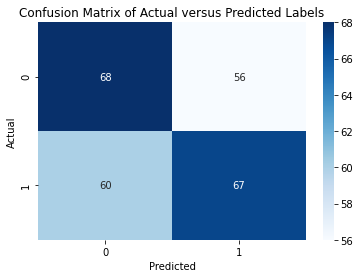

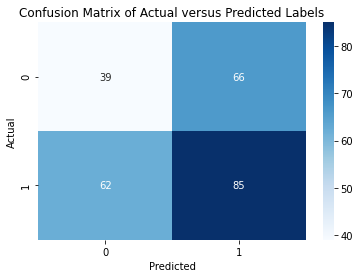

In [14]:
def confusion_matrix(model, x, y):
    y_pred = model.predict(x, batch_size=1)

    originals = []
    predictions = []

    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))
        
    df = pd.DataFrame()
    df['Actual'] = originals
    df['Predicted'] = predictions
    
    conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
    sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    plt.title("Confusion Matrix of Actual versus Predicted Labels")
    plt.show()
    
# confusion_matrix(model, x_train, y_train)
confusion_matrix(model, x_val, y_val)
confusion_matrix(model, x_test, y_test)

In [15]:
def retrieve_candles(filename, val_year, test_year):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.columns = ["Date", "Close", "Open", "High", "Low", "Vol.", "Change%"]
    df = df.sort_values('Date', ascending=True)
    
    candles_val = df[df['Date'].dt.year == val_year]
    candles_train = df[df['Date'].dt.year < val_year]
    candles_train = candles_train[candles_train['Date'] > datetime(2009,7,10)]
    
    candles_train = candles_train.replace(',','', regex=True)
    candles_val = candles_val.replace(',','', regex=True)

    return candles_train, candles_val

def plot_predictions_candles(x, y, df, dataset):
    # PREDICTIONS LIJKEN NOG NIET GOED UITGELIJND MET CANDLES???
    originals = []
    predictions = []
    y_pred = model.predict(x)
    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))

    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name="Price"))
    standard_factor = 0.5 * mean([float(df.iloc[0].tolist()[3]), float(df.iloc[0].tolist()[4])])
    
    green_legend = False
    orange_legend = False
    red_legend = False
    
    for i, row in enumerate(df.iterrows()):
        pred_date = row[1][0].to_pydatetime()
        pred_high = float(row[1][3])
        pred_low = float(row[1][4])
#         real_label = row[1][7]
#         pred_label = row[1][8]
        real_label = originals[i]
        pred_label = predictions[i]
        
        start_shape = pred_date - timedelta(days=0.1)
        end_shape = pred_date + timedelta(days=0.1)
    
        
        if pred_label == 1:
            extreme = pred_high + 0.1 * standard_factor
            standard = pred_high + 0.05 * standard_factor
#         elif pred_label == 2:
#             extreme = pred_high + 0.2 * standard_factor
#             standard = pred_high + 0.05 * standard_factor
        elif pred_label == 0:
            extreme = pred_low - 0.1 * standard_factor
            standard = pred_low -  0.05 * standard_factor
#         elif pred_label == -2:
#             extreme = pred_low - 0.2 * standard_factor
#             standard = pred_low - 0.05 * standard_factor
            
        if real_label == pred_label:
            color = "green"
#         elif np.sign(real_label) == np.sign(pred_label):
#             color = "orange"
        else:
            color = "red"
        
        if real_label == pred_label and not green_legend:
            green_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction", mode="lines", line=dict(color=color)))
        
#         elif np.sign(real_label) == np.sign(pred_label) and not orange_legend:
#             orange_legend = True
#             fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
#                                  y=[standard,extreme,standard,standard], 
#                                  fill="toself", name="Correct Direction / Inorrect Magnitude", mode="lines", line=dict(color=color)))
        elif real_label != pred_label and not red_legend:
            red_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Incorrect Direction", mode="lines", line=dict(color=color)))
        else:
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", showlegend=False, mode="lines", line=dict(color=color)))
    
    title = f"Visualization of {dataset} Predictions"
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    layout = dict(title=title, height=800, width=1500)
    fig.update_layout(layout)
#     config = dict({'scrollZoom': True})
#     fig.show(config=config)
    fig.show()

filename = "Dataset v3/Indices/S&P 500 Historical Data.csv"
candles_train, candles_val = retrieve_candles(filename, val_year, test_year) 
# plot_predictions_candles(x_train, y_train, candles_train, "Training")
plot_predictions_candles(x_val, y_val, candles_val, "Validation")